# Thermo-mechanical NTFA - Generate plots

(c) 2024, 
Felix Fritzen <fritzen@simtech.uni-stuttgart.de>,
Julius Herb <julius.herb@mib.uni-stuttgart.de>,
Shadi Sharba <shadi.sharba@isc.fraunhofer.de>

University of Stuttgart, Institute of Applied Mechanics, Chair for Data Analytics in Engineering


> **Funding acknowledgment**
> The IGF-Project no.: 21.079 N / DVS-No.: 06.3341 of the “Forschungsvereinigung Schweißen und verwandte Verfahren e.V.” of the German Welding Society (DVS), Aachener Str. 172, 40223 Düsseldorf, Germany, was funded by the Federal Ministry for Economic Affairs and Climate Action (BMWK) via the German Federation of Industrial Research Associations (AiF) in accordance with the policy to support the Industrial Collective Research (IGF) on the orders of the German Bundestag.</br>
> <img src="data/bmwk.png" width="20%"></img>
>
> Felix Fritzen is funded by the German Research Foundation (DFG) -- 390740016 (EXC-2075); 406068690 (FR2702/8-1); 517847245 (FR2702/10-1).

## Imports

In [1]:
import os
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
from thermo_ntfa import TabularInterpolation

matplotlib.rc('font', size=14)


def Vec2Tensor(vec):
    """ Convert a 6-vector (in Mandel notation) into a sym. 3x3 Matrix

    """
    A = np.zeros((3, 3))
    A[0, 0] = vec[0]
    A[1, 1] = vec[1]
    A[2, 2] = vec[2]
    A[0, 1] = np.sqrt(0.5) * vec[3]
    A[1, 0] = A[0, 1]
    A[0, 2] = np.sqrt(0.5) * vec[4]
    A[2, 0] = A[0, 2]
    A[1, 2] = np.sqrt(0.5) * vec[5]
    A[2, 1] = A[1, 2]
    return A

## Read tabular data for NTFA matrices from file

In [2]:
mode_file_name = os.path.join("data", "simple_3d_rve_B1-B6_16x16x16_10samples_fix.h5")
A_bar = TabularInterpolation()
A_bar.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A_bar", transpose=(2, 0, 1))
C_bar = TabularInterpolation()
C_bar.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C_bar", transpose=(2, 0, 1))
A_cu = TabularInterpolation()
A_cu.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A0", transpose=(2, 0, 1))
A_wsc = TabularInterpolation()
A_wsc.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A1", transpose=(2, 0, 1))
C_cu = TabularInterpolation()
C_cu.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C0", transpose=(2, 0, 1))
C_wsc = TabularInterpolation()
C_wsc.InitH5(mode_file_name, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C1", transpose=(2, 0, 1))

# number of modes - needed to truncate A!
N_modes = 18
A_bar.data = A_bar.data[:, :, :N_modes]
A_cu.data = A_cu.data[:, :, :(7 + N_modes)]
A_wsc.data = A_wsc.data[:, :, :(7 + N_modes)]

for I in [A_bar, A_cu, A_wsc]:
    I.dim = I.data.shape

## Analysis of the two-scale simulation
### Determine an element in the notch:

In [3]:
F = h5py.File(os.path.join("data", "NTFA293K_fine_temp_293-800.h5"), "r")

# step 1: find the element with the crucial pieces of information
# read mesh
vx = np.array(F["/mesh/X"]).reshape((-1, 3))
el = np.array(F["/mesh/el_vx_idx"]).reshape((-1, 10))
n_el = np.array(F["/mesh/n_el"])[0]
n_vx = np.array(F["/mesh/n_vx"])[0]
gp_idx = np.array(F["/mesh/DPIdx"])

# get element centers
el_center = np.zeros((n_el, 3))
for i_el in range(n_el):
    el_center[i_el, :] = np.mean(vx[el[i_el, :], :], axis=0)

# find the element center closest to 0., 2.5, 0.
dist = np.linalg.norm(el_center - np.array([5., 0, 2.5])[None, :], axis=1)
i_min = np.argmin(dist)
print(f"element closest to [5., 0., 2.5]: {i_min} with element center {el_center[i_min]}")

element closest to [5., 0., 2.5]: 10819 with element center [ 4.42104823 -0.50041445  2.49541378]


### Extract the strain, temperature, stress, qbar, xi, sig_cu, sig_wsc history:

vicinity of the notch (at the center of the specimen)

In [4]:
n_inc = max([int(key.replace("DATA", "")) for key in F.keys() if key.startswith("DATA")])
theta = np.zeros(n_inc + 1)
eps = np.zeros((n_inc + 1, 6))
sig = np.zeros((n_inc + 1, 6))
sig_cu = np.zeros((n_inc + 1, 6))
sig_wsc = np.zeros((n_inc + 1, 6))
qbar = np.zeros(n_inc + 1)
xi = np.zeros((n_inc + 1, N_modes))
zeta = np.zeros((n_inc + 1, N_modes + 7))
idat_start = np.array(F["/Data/step1/n_iD"][:gp_idx[i_min]]).sum()
idat_end = idat_start + F["/Data/step1/n_iD"][gp_idx[i_min]]
n_gp = F["/Data/step1/n_gp"][0]
theta[0] = 293
for i in range(n_inc):
    j = i + 1
    theta[j] = np.array(F[f"/temperature{j}"])[j]
    cdat = np.array(F[f"/Data/step{i + 1}/cData"][gp_idx[i_min]])
    # cdat = np.array( F[f"/Data/step{i+1}/cData"]).reshape((-1,12))
    eps[j, :] = cdat[:6]
    sig[j, :] = cdat[6:]
    idat = np.array(F[f"/Data/step{i + 1}/iData"])[idat_start:idat_end]
    xi[j, :] = idat[1:(N_modes + 1)]
    qbar[j] = idat[0]
    zeta[j, :6] = eps[j, :]
    zeta[j, 6] = 1
    zeta[j, 7:] = xi[j, :]
    sig_cu[j, :] = A_cu.interpolate(theta[j]) @ zeta[j, :]
    sig_wsc[j, :] = A_wsc.interpolate(theta[j]) @ zeta[j, :]
F.close()

### Compute and plot some stress information:

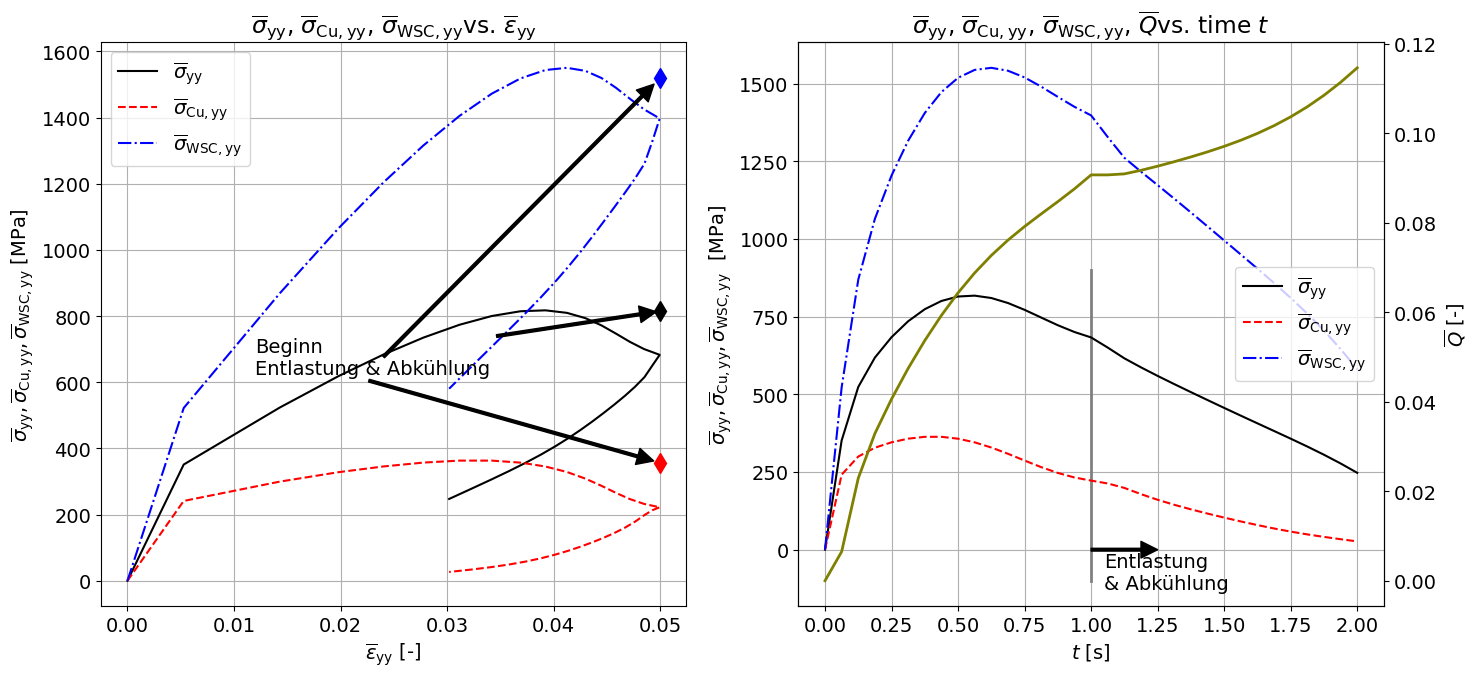

In [5]:
sig_h = sig[:, :3].sum(axis=1) / 3
sig_h_cu = sig_cu[:, :3].sum(axis=1) / 3
sig_h_wsc = sig_wsc[:, :3].sum(axis=1) / 3
sig_eq = np.sqrt(1.5 * np.maximum(0.0, np.linalg.norm(sig, axis=1) ** 2 - 3 * sig_h * sig_h))
sig_eq_cu = np.sqrt(1.5 * np.maximum(0.0, np.linalg.norm(sig_cu, axis=1) ** 2 - 3 * sig_h_cu * sig_h_cu))
sig_eq_wsc = np.sqrt(1.5 * np.maximum(0.0, np.linalg.norm(sig_wsc, axis=1) ** 2 - 3 * sig_h_wsc * sig_h_wsc))
sig_I_wsc = np.zeros(sig.shape[0])
sig_II_wsc = np.zeros(sig.shape[0])
sig_III_wsc = np.zeros(sig.shape[0])
sig_I_cu = np.zeros(sig.shape[0])
sig_II_cu = np.zeros(sig.shape[0])
sig_III_cu = np.zeros(sig.shape[0])
for i in range(n_inc + 1):
    sig_III_cu[i], sig_II_cu[i], sig_I_cu[i] = np.linalg.eigvalsh(Vec2Tensor(sig_cu[i]))
    sig_III_wsc[i], sig_II_wsc[i], sig_I_wsc[i] = np.linalg.eigvalsh(Vec2Tensor(sig_wsc[i]))

t = np.linspace(0, 2, n_inc + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(eps[:, 1], sig[:, 1] / 1000, color='black', label=r"$\overline{\sigma}_{\sf yy}$")
ax[0].plot(eps[:, 1], sig_cu[:, 1] / 1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu, yy}$")
ax[0].plot(eps[:, 1], sig_wsc[:, 1] / 1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC, yy}$")
ax[0].set_title(
    r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$, $\overline{\sigma}_{\sf WSC, yy}$"
    r"vs. $\overline{\varepsilon}_{\sf yy}$")
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel(r"$\overline{\varepsilon}_{\sf yy}$ [-]")
ax[0].set_ylabel(r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf WSC, yy}$ [MPa]")
eyy_max = max(eps[:, 1])
syy = sig[8, 1] / 1000
syy_cu = sig_cu[8, 1] / 1000
syy_wsc = sig_wsc[8, 1] / 1000
arrowprops = dict(facecolor='black', shrink=0.02, width=2, headwidth=12, headlength=12)
ax[0].annotate("Beginn\nEntlastung & Abkühlung", xy=(eyy_max, syy), xytext=(0.012, 625), arrowprops=arrowprops)
ax[0].annotate("", xy=(eyy_max, syy_cu), xytext=(0.0221, 610), arrowprops=arrowprops)
ax[0].annotate("", xy=(eyy_max, syy_wsc), xytext=(0.0235, 660), arrowprops=arrowprops)
ax[0].plot(eyy_max, syy_cu, 'd', color='red', ms=10)
ax[0].plot(eyy_max, syy_wsc, 'd', color='blue', ms=10)
ax[0].plot(eyy_max, syy, 'd', color='black', ms=10)

ax[1].plot((1, 1), (-100, 900), lw=2, color='gray')
ax[1].text(1.05, -125, "Entlastung\n& Abkühlung")
ax[1].annotate("", xy=(1.25, 0), xytext=(1, 0),
               arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))
ax[1].plot(t, sig[:, 1] / 1000, color='black', label=r"$\overline{\sigma}_{\sf yy}$")
ax[1].plot(t, sig_cu[:, 1] / 1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu,yy}$")
ax[1].plot(t, sig_wsc[:, 1] / 1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC,yy}$")
ax[1].set_title(
    r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$, $\overline{\sigma}_{\sf WSC, yy}$, $\overline{Q}$"
    r"vs. time $t$")
ax2 = ax[1].twinx()
ax[1].legend(loc='center right')
ax[1].grid()
ax2.plot(t, qbar, label=r"$\overline{Q}$", color='olive', lw=2)
ax[1].set_xlabel(r"$t$ [s]")
ax[1].set_ylabel(
    r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf WSC, yy}$  [MPa]")
ax2.set_ylabel(r"$\overline{Q}$ [-]")
plt.tight_layout()
plt.savefig(os.path.join("results", "notchtest_fine_sigyy_ntfa.pdf"), format="pdf")
plt.show()

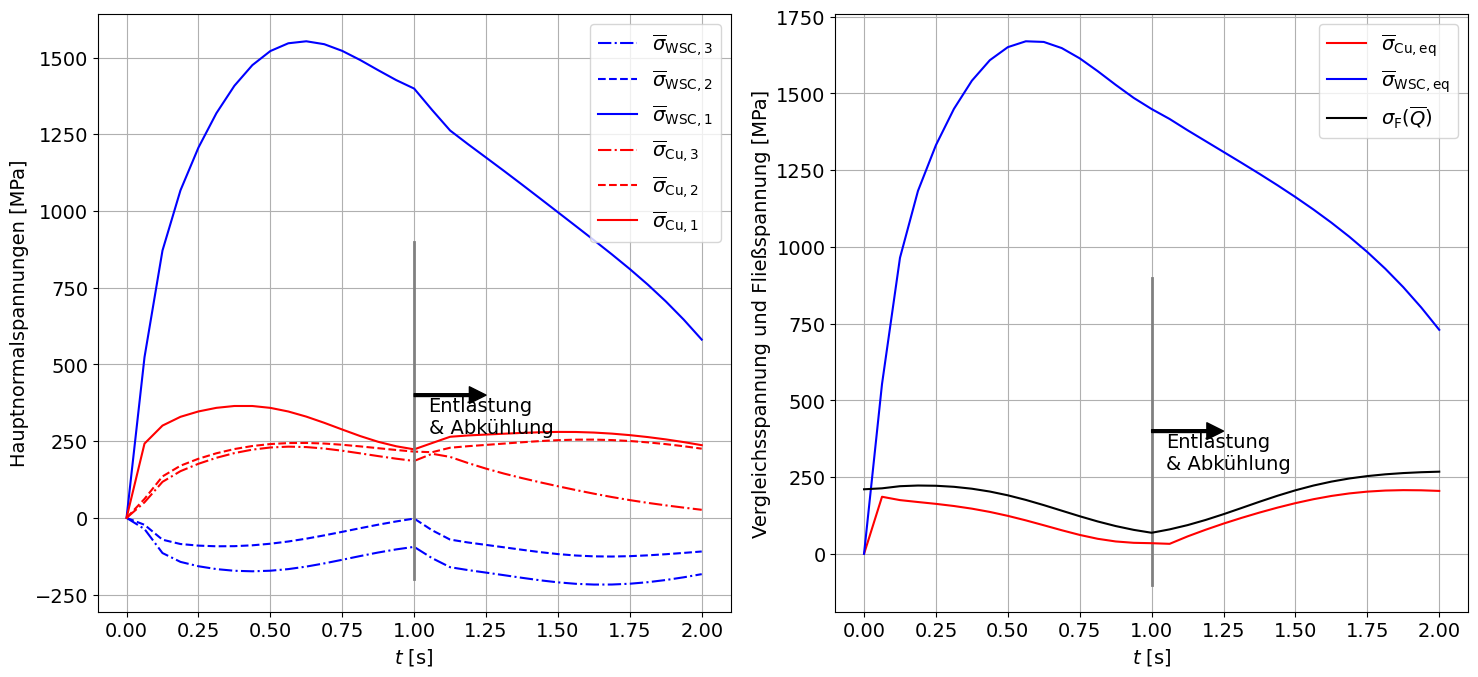

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(t, sig_III_wsc / 1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC, 3}$")
ax[0].plot(t, sig_II_wsc / 1000, '--', color='blue', label=r"$\overline{\sigma}_{\sf WSC, 2}$")
ax[0].plot(t, sig_I_wsc / 1000, color='blue', label=r"$\overline{\sigma}_{\sf WSC, 1}$")
ax[0].plot(t, sig_III_cu / 1000, '-.', color='red', label=r"$\overline{\sigma}_{\sf Cu, 3}$")
ax[0].plot(t, sig_II_cu / 1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu, 2}$")
ax[0].plot(t, sig_I_cu / 1000, color='red', label=r"$\overline{\sigma}_{\sf Cu, 1}$")
ax[0].legend(ncol=1)  #loc='center right')
ax[0].grid()
ax[0].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"Hauptnormalspannungen [MPa]")
ax[0].plot((1, 1), (-200, 900), lw=2, color='gray')
ax[0].text(1.05, 275, "Entlastung\n& Abkühlung")
ax[0].annotate("", xy=(1.25, 400), xytext=(1, 400),
               arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))


def yield_cu(x):
    return (1.12133e+02 * x + 3.49810e+04 + 1.53393e+05 * np.tanh(
        (x / 1000 + -6.35754e-01) / -2.06958e-01)) * (x < 1000) + 1200. * (x >= 1000.0)


sig_y = np.zeros_like(t)
for i, T in enumerate(theta):
    sig_y[i] = yield_cu(theta[i]) + 500000 * qbar[i]

ax[1].plot((1, 1), (-100, 900), lw=2, color='gray')
ax[1].text(1.05, 275, "Entlastung\n& Abkühlung")
ax[1].annotate("", xy=(1.25, 400), xytext=(1, 400),
               arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))
# ax[1].plot(t, sig_h_cu/1000, '-', color='red', label=r"$\overline{\sigma}_{\sf Cu, h}$")
ax[1].plot(t, sig_eq_cu / 1000, '-', color='red', label=r"$\overline{\sigma}_{\sf Cu, eq}$")
# ax[1].plot(t, sig_h_wsc/1000, '-', color='blue', label=r"$\overline{\sigma}_{\sf WSC, h}$")
ax[1].plot(t, sig_eq_wsc / 1000, '-', color='blue', label=r"$\overline{\sigma}_{\sf WSC, eq}$")
ax[1].plot(t, sig_y / 1000, '-', color='black', label=r"$\sigma_{\sf F}(\overline{Q})$")
ax[1].legend(ncol=1, loc='upper right')
ax[1].grid()
ax[1].set_xlabel(r"$t$ [s]")
ax[1].set_ylabel(r"Vergleichsspannung und Fließspannung [MPa]")
plt.tight_layout()
plt.savefig(os.path.join("results", "notchtest_fine_sigeq_ntfa.pdf"), format="pdf")
plt.show()

### Pass the strain, temperature history to FANS as BC

In [7]:
F = h5py.File(os.path.join("data", "daten_kerbgrund.h5"), "w")
F.create_dataset("/sig", data=sig)
F.create_dataset("/sig_cu", data=sig_cu)
F.create_dataset("/sig_wsc", data=sig_wsc)
F.create_dataset("/eps", data=eps)
F.create_dataset("/theta", data=theta)

F.create_dataset("/time", data=t)
F.close()
# ax2=ax[1].twinx()
# ax2.plot(t, eps[:,1], color='black')
# ax2.plot(t, qbar[:], color='red')
# ax1].plot(t, sig_cu[:,1]/1000, '--', color='red')
# ax2.plot(t, sig_wsc[:,1]/1000, '-.', color='blue')

# ax2.plot(eps[:,1], sig_cu[:,1]/1000, '--', color='red')
# ax2.plot(eps[:,1], sig_wsc[:,1]/1000, '-.', color='blue')
print(theta)

[293.     324.6875 356.375  388.0625 419.75   451.4375 483.125  514.8125
 546.5    578.1875 609.875  641.5625 673.25   704.9375 736.625  768.3125
 800.     768.3125 736.625  704.9375 673.25   641.5625 609.875  578.1875
 546.5    514.8125 483.125  451.4375 419.75   388.0625 356.375  324.6875
 293.    ]


### Compare the results:

#### Load data from hdf5 files:

In [8]:
file_name = os.path.join("data", "daten_kerbgrund_32s_fans.h5")
with h5py.File(file_name, "r") as F:
    eps = np.array(F["/eps"])
    theta = np.array(F["/theta"])
    fans_sig = np.array(F["/fe/sig"])
    fans_sig_cu = np.array(F["/fe/sig0"])
    fans_sig_wsc = np.array(F["/fe/sig1"])
    ntfa_sig = np.array(F["/sig"])
    ntfa_sig_cu = np.array(F["/sig_cu"])
    ntfa_sig_wsc = np.array(F["/sig_wsc"])
    #ntfa_q = np.array(F["/ntfa/q"])
    #ntfa_xi = np.array(F["/ntfa/xi"])

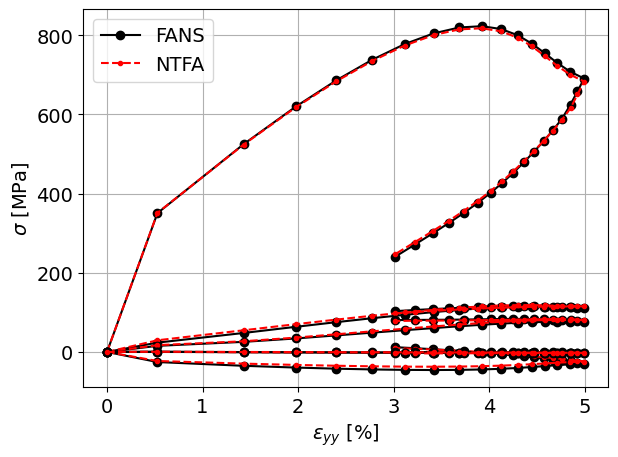

In [9]:
for i in [0, 1, 2, 3, 4, 5]:
    plt.plot(eps[:,1] * 100., fans_sig[:,i] / 1000, 'k-o')
    plt.plot(eps[:,1] * 100., ntfa_sig[:,i] / 1000, 'r--.')
plt.legend(['FANS', 'NTFA'])
plt.xlabel(r'$\varepsilon_{yy}$ [%]')
plt.ylabel(r'$\sigma$ [MPa]')
plt.grid()
plt.tight_layout()
plt.show()

### Load H5 file with all results:

In [10]:
# file_name = os.path.join("data", "all_results_ms9p_16x16x16_10s_N24.h5")
file_name = os.path.join("data", f"all_results_ms9p_16x16x16_100s_N{N_modes}.h5")
with h5py.File(file_name, "r") as F:
    eps = np.array(F["/eps"])
    theta = np.array(F["/temperature"])
    fans_sig = np.array(F["/fans/sig"])
    fans_sig_cu = np.array(F["/fans/sig0"])
    fans_sig_wsc = np.array(F["/fans/sig1"])
    ntfa_sig = np.array(F["/ntfa/sig"])
    ntfa_sig_cu = np.array(F["/ntfa/sig0"])
    ntfa_sig_wsc = np.array(F["/ntfa/sig1"])
    ntfa_q = np.array(F["/ntfa/q"])
    ntfa_xi = np.array(F["/ntfa/xi"])

#### Compare efficiency of the interpolation over the temperature:

(100, 6, 11, 6)


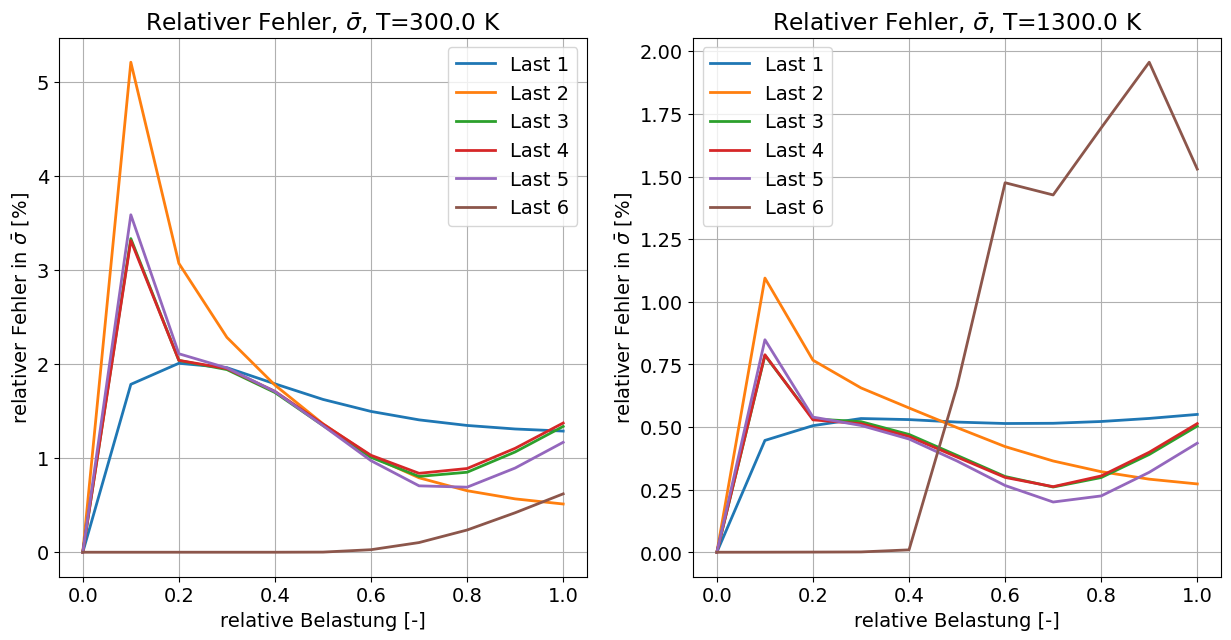

In [11]:
print(fans_sig.shape)
fig, axx = plt.subplots(1, 2, figsize=(15, 7))
ct = 0
for i_T, T in zip((0, 9), (300., 1300.)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r'Relativer Fehler, $\bar{\sigma}$, T=%.1f K' % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel('relative Belastung [-]')
    ax.set_ylabel(r'relativer Fehler in $\bar{\sigma}$ [%]')
    for iload in range(6):
        myerr = np.linalg.norm(fans_sig[i_T][iload][:, :] - ntfa_sig[i_T][iload][:, :], axis=1) \
                * 100. / np.linalg.norm(fans_sig[i_T][iload][:, :], axis=1)
        ax.plot(x, myerr, lw=2, label=f'Last {iload + 1}')
        # print(np.max(myerr))
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig(os.path.join("results", "rel_err_sig_10s.pdf"), format="pdf")
plt.show()

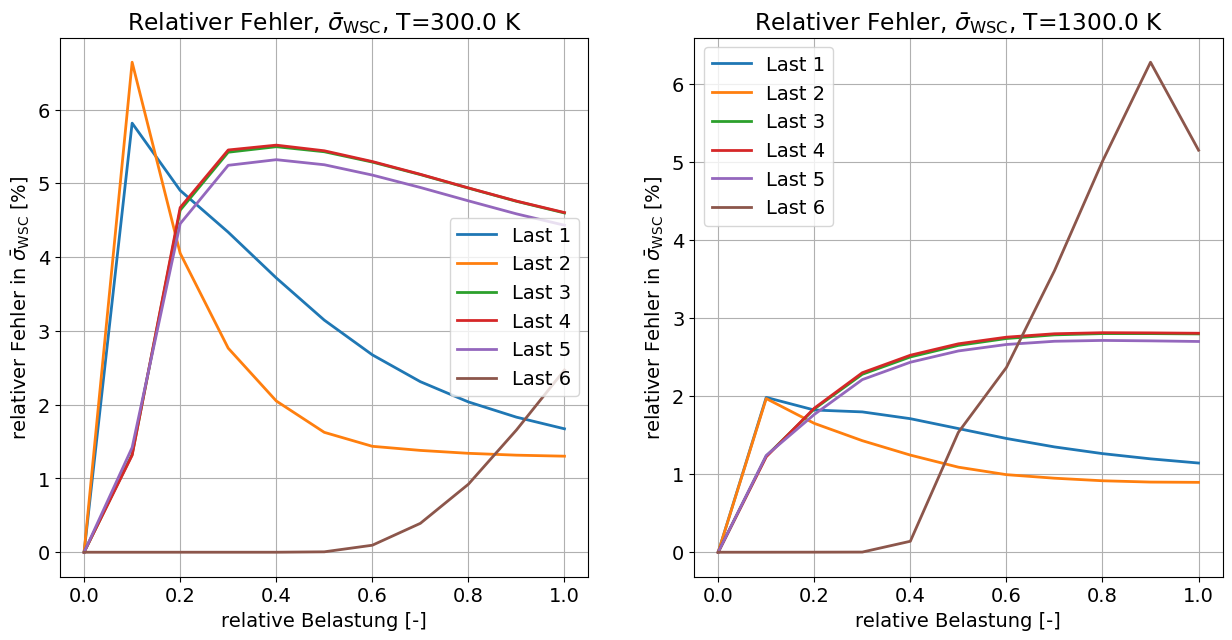

In [12]:
fig, axx = plt.subplots(1, 2, figsize=(15, 7))
ct = 0
for i_T, T in zip((0, 9), (300., 1300.)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r'Relativer Fehler, $\bar{\sigma}_{\rm WSC}$, T=%.1f K' % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel('relative Belastung [-]')
    ax.set_ylabel(r'relativer Fehler in $\bar{\sigma}_{\sf WSC}$ [%]')
    for iload in range(6):
        myerr = np.linalg.norm(fans_sig_wsc[i_T][iload][:, :] - ntfa_sig_wsc[i_T][iload][:, :], axis=1) \
                * 100. / np.linalg.norm(fans_sig_wsc[i_T][iload][:, :], axis=1)
        # myerr[0] = 0.
        ax.plot(x, myerr, lw=2, label=f'Last {iload + 1}')
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig(os.path.join("results", "rel_err_sig_wsc_10s.pdf"), format="pdf")
plt.show()

In [13]:
err = np.zeros((theta.size, fans_sig.shape[2]))
err0 = np.zeros_like(err)
err1 = np.zeros_like(err)
err_h = np.zeros_like(err)
err_eq = np.zeros_like(err)
zeta = np.zeros((eps.shape[2], ntfa_xi.shape[-1] + 7))
iload = 2
for i_T, T in enumerate(theta):
    Sref = fans_sig[i_T, iload]
    Sref0 = fans_sig_cu[i_T, iload]
    Sref1 = fans_sig_wsc[i_T, iload]
    # recompute stress of NTFA:
    zeta[:, :6] = eps[i_T, iload]
    zeta[:, 6] = 1
    zeta[:, 7:] = ntfa_xi[i_T, iload]
    ntfa_S0 = zeta @ (A_cu.interpolate(T)).T
    ntfa_S1 = zeta @ (A_wsc.interpolate(T)).T
    dS = Sref - ntfa_sig[i_T, iload, :, :]
    dS0 = Sref0 - ntfa_S0
    dS1 = Sref1 - ntfa_S1
    # dS0 = Sref0 - ntfa_sig_cu[i,iload,:,:]
    # dS1 = Sref1 - ntfa_sig_wsc[i,iload,:,:]
    # errors in %
    err[i_T, :] = np.linalg.norm(dS, axis=1) / np.linalg.norm(Sref, axis=1) * 100
    err0[i_T, :] = np.linalg.norm(dS0, axis=1) / np.linalg.norm(Sref0, axis=1) * 100
    err1[i_T, :] = np.linalg.norm(dS1, axis=1) / np.linalg.norm(Sref1, axis=1) * 100
    # in MPa:
    err_h[i_T, :] = dS[:, :3].sum(axis=1) / 3. / 1000.
    err_eq[i_T, :] = np.maximum(0, np.linalg.norm(dS, axis=1) ** 2 - 3 * err_h[i, :] ** 2) * np.sqrt(1.5) / 1000.

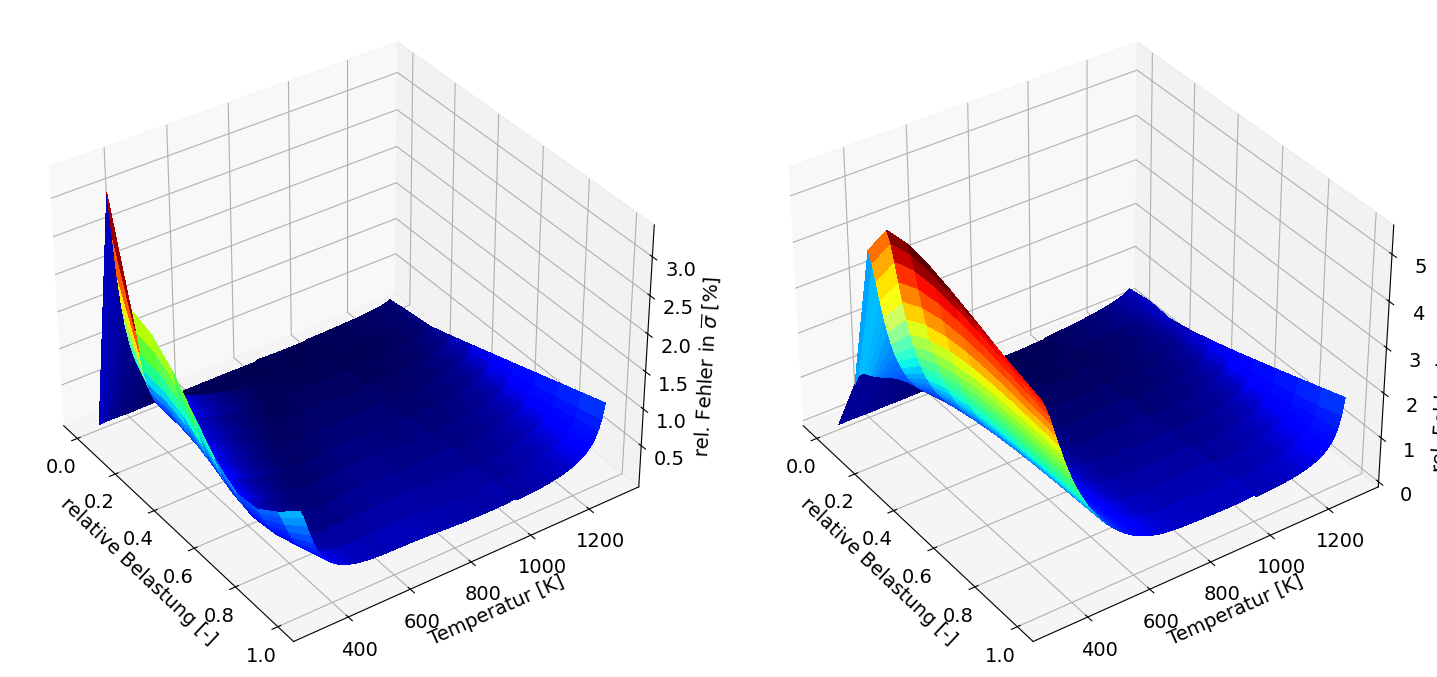

In [14]:
X = np.linspace(0, 1, fans_sig.shape[2])
Y = theta
XX, YY = np.meshgrid(X, Y)

fig, axx = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(15, 7))

ax = axx[0]

ls = LightSource(220, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
ZZ = err
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode='soft')
ax.view_init(elev=35, azim=-35)
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)

ax.set_xlabel("relative Belastung [-]")
ax.set_ylabel("Temperatur [K]")
ax.set_zlabel(r"rel. Fehler in $\overline{\sigma}$ [%]")

ax = axx[1]

ls = LightSource(220, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
ZZ = err1
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode='soft')
ax.view_init(elev=35, azim=-35)
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)

ax.set_xlabel("relative Belastung [-]")
ax.set_ylabel("Temperatur [K]")
ax.set_zlabel(r"rel. Fehler in $\overline{\sigma}_{\sf WSC}$ [%]")

fig.tight_layout()

plt.savefig(os.path.join("results", "surface_plots_err_sig_sig_wsc.pdf"), format="pdf")
plt.show()

# ax[0].plot(theta, err, '-', color='black', label=r"$e_{\overline{\sigma}}$ [%]")
# ax[0].plot(theta, err0, '--', color='red', label=r"$e_{\overline{\sigma},\sf Cu}$ [%]")
# ax[0].plot(theta, err1, '-.', color='blue', label=r"$e_{\overline{\sigma},\sf Cu}$ [%]")

# ax[1].plot(theta, err_eq, '-', color='black', label=r"$e_{\overline{\sigma}},\sf eq$ [MPa]")

#### Show select stress-strain curves:

In [15]:
with h5py.File(os.path.join("data", "daten_kerbgrund_JH_fixed.h5"), "r") as F:  # daten_kerbgrund_NTFA_FE.h5
    eps = np.array(F["/eps"])
    ntfa_S = np.array(F["/sig"]) / 1e3
    ntfa_S0 = np.array(F["/sig_cu"]) / 1e3
    ntfa_S1 = np.array(F["/sig_wsc"]) / 1e3
    fe_S = np.array(F["/fe/sig"]) / 1e3
    fe_S0 = np.array(F["/fe/sig0"]) / 1e3
    fe_S1 = np.array(F["/fe/sig1"]) / 1e3
# with h5py.File("/home/fritzen/Nextcloud/FNO/daten_kerbgrund_JH.h5", "r") as F:
#     eps = np.array(F["/eps"])
#     # ntfa_S = np.array(F["/sig"])/1e3
#     # ntfa_S0 = np.array(F["/sig_cu"])/1e3
#     # ntfa_S1 = np.array(F["/sig_wsc"])/1e3
#     fe_S = np.array(F["/fe/sig"])/1e3
#     fe_S0 = np.array(F["/fe/sig0"])/1e3
#     fe_S1 = np.array(F["/fe/sig1"])/1e3

# with h5py.File("daten_kerbgrund.h5", "r") as F:
#     ntfa_S = np.array(F["/sig"])/1e3
#     ntfa_S0 = np.array(F["/sig_cu"])/1e3
#     ntfa_S1 = np.array(F["/sig_wsc"])/1e3

# with h5py.File("/home/fritzen/Nextcloud/FNO/daten_kerbgrund_JH_fixed.h5", "w") as F:
#     with h5py.File("daten_kerbgrund.h5", "r") as G:
#         # copy existing data
#         for k in G.keys():
#             F.create_dataset(k, data=G[k])
#     with h5py.File("/home/fritzen/Nextcloud/FNO/daten_kerbgrund_JH.h5", "r") as G:
#         for k in ["/fe/sig", "/fe/sig0", "/fe/sig1"]:
#             F.create_dataset(k, data=G[k])

/tmp/ipykernel_140517/948844680.py:26: RuntimeWarning: invalid value encountered in divide
  err = np.linalg.norm(dS, axis=1) / np.linalg.norm(fe_S, axis=1)
/tmp/ipykernel_140517/948844680.py:27: RuntimeWarning: invalid value encountered in divide
  err1 = np.linalg.norm(dS1, axis=1) / np.linalg.norm(fe_S1, axis=1)


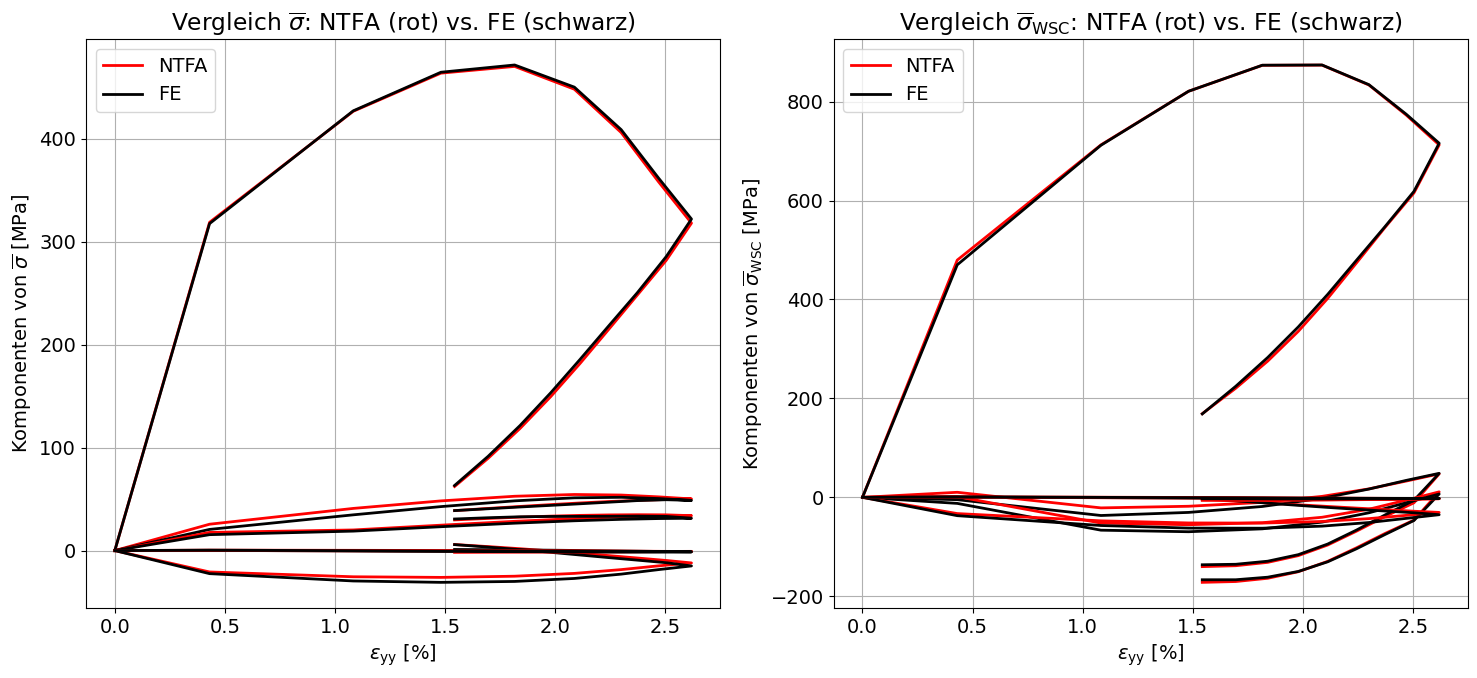

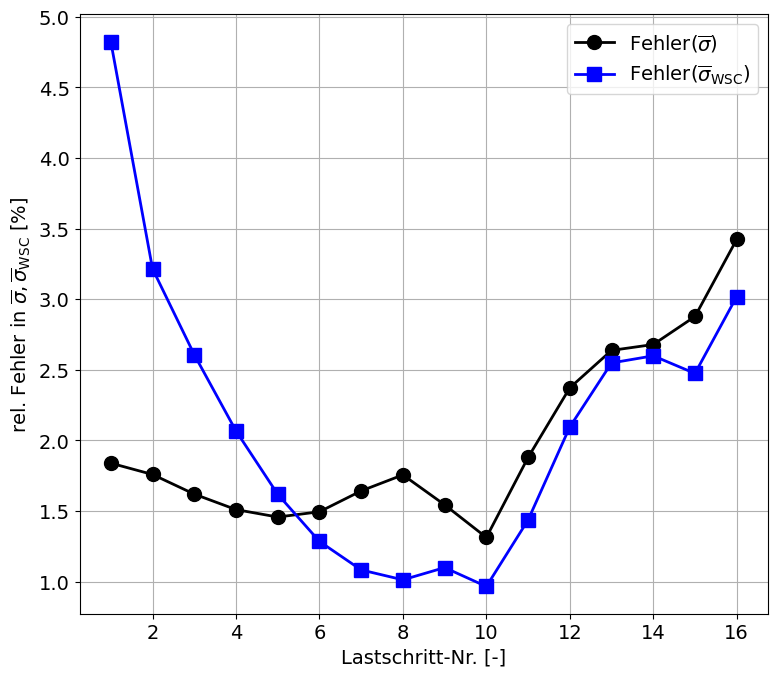

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
for i in range(6):
    if (i == 0):
        label_fe = "FE"
        label_ntfa = "NTFA"
    else:
        label_fe = None
        label_ntfa = None
    ax[0].plot(eps[:, 1] * 100, ntfa_S[:, i], color='red', lw=2, label=label_ntfa)
    ax[0].plot(eps[:, 1] * 100, fe_S[:, i], color='black', lw=2, label=label_fe)
    ax[1].plot(eps[:, 1] * 100, ntfa_S1[:, i], color='red', lw=2, label=label_ntfa)
    ax[1].plot(eps[:, 1] * 100, fe_S1[:, i], color='black', lw=2, label=label_fe)
ax[0].set_title(r"Vergleich $\overline{{\sigma}}$: NTFA (rot) vs. FE (schwarz)")
ax[1].set_title(r"Vergleich $\overline{{\sigma}}_{\sf WSC}$: NTFA (rot) vs. FE (schwarz)")
for a in ax:
    a.grid()
    a.legend()
    a.set_xlabel(r"$\varepsilon_{\sf yy}$ [%]")
ax[0].set_ylabel(r"Komponenten von $\overline{{\sigma}}$ [MPa]")
ax[1].set_ylabel(r"Komponenten von $\overline{{\sigma}}_{\sf WSC}$ [MPa]")
fig.tight_layout()
plt.savefig("kerbgrund_sig_sig_wsc.pdf", format="pdf")

dS = fe_S - ntfa_S
dS1 = fe_S1 - ntfa_S1
err = np.linalg.norm(dS, axis=1) / np.linalg.norm(fe_S, axis=1)
err1 = np.linalg.norm(dS1, axis=1) / np.linalg.norm(fe_S1, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
ax.plot(err * 100, 'o-', ms=10, color='black', lw=2, label=r"Fehler$(\overline{\sigma})$")
ax.plot(err1 * 100, 's-', ms=10, color='blue', lw=2, label=r"Fehler$(\overline{\sigma}_{\sf WSC})$")
ax.legend()
ax.grid()
ax.set_xlabel("Lastschritt-Nr. [-]")
ax.set_ylabel(r"rel. Fehler in $\overline{\sigma}, \overline{\sigma}_{\sf WSC}$ [%]")
fig.tight_layout()
plt.savefig(os.path.join("results", "kerbgrund_err_sig_sig_wsc.pdf"), format="pdf")
plt.show()